# Домашнее задание 4

В последнем практическом задании мы потренируемся в построении VaR-кривой для небольшого портфеля.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, date
import time

import seaborn as sns
import scipy.stats as ss
import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

import warnings
warnings.filterwarnings("ignore")

In [2]:
#!pip install yfinance
#!pip install arch

In [3]:
import yfinance as yf
from arch import arch_model

### 1) Загрузка данных (0.5 балла)

* Представьте, что вы инвестор и собираете инвестиционный портфель. 

* Загрузите данные по трём любым акциям и двум любым валютам за последние 10 лет. Акции и валюты выберите на ваш вкус, но интереснее будет взять что-то кроме евро/доллара/акций гугла.

* Можно использовать YachooFinance либо другие источники при желании.




In [4]:
companies = 'CNY=X EURUSD=X T DIS NFLX' 

data = yf.download(companies, '2012-01-01', group_by="column")

data.head()

[*********************100%***********************]  5 of 5 completed


Adj Close                                              Close  \
               CNY=X        DIS  EURUSD=X       NFLX          T   CNY=X   
Date                                                                      
2012-01-02    6.2850        NaN  1.296008        NaN        NaN  6.2850   
2012-01-03    6.2840  34.300617  1.294096  10.320000  10.388862  6.2840   
2012-01-04    6.2970  34.784103  1.305602  11.492857  10.405959  6.2970   
2012-01-05    6.2960  35.366070  1.293142  11.328571  10.395700  6.2960   
2012-01-06    6.3085  35.733166  1.279607  12.327143  10.347781  6.3085   

                                                       ...    Open             \
                  DIS  EURUSD=X       NFLX          T  ...   CNY=X        DIS   
Date                                                   ...                      
2012-01-02        NaN  1.296008        NaN        NaN  ...  6.2840        NaN   
2012-01-03  38.310001  1.294096  10.320000  22.945620  ...  6.2840  37.970001   
2012-01-04  38.849998  1.305602  11.492857  22.983383  ...  6.2841  38.189999   
2012-01-05  39.500000  1.293142  11.328571  22.960726  ...  6.2826  38.830002   
2012-01-06  39.910000  1.279607  12.327143  22.416918  ...  6.2924  39.549999   

                                           Volume                       \
            EURUSD=X       NFLX          T  CNY=X         DIS EURUSD=X   
Date                                                                     
2012-01-02  1.296008        NaN        NaN    0.0         NaN      0.0   
2012-01-03  1.293628  10.040000  23.006042    0.0   9704200.0      0.0   
2012-01-04  1.305398  10.335714  23.096678    0.0   9889900.0      0.0   
2012-01-05  1.293092  11.345714  23.028702    0.0  14327100.0      0.0   
2012-01-06  1.279296  11.302857  22.711479    0.0  14401600.0      0.0   

                                     
                   NFLX           T  
Date                                 
2012-01-02          NaN         NaN  
2012-01-03   29213800.0  43699017.0  
2012-01-04  100489900.0  49271204.0  
2012-01-05   86552900.0  45621068.0  
2012-01-06  125610800.0  60348979.0  

[5 rows x 30 columns]

In [5]:
prices = data['Adj Close'].dropna()
print(prices.shape)
prices.head()

(2613, 5)


,CNY=X,DIS,EURUSD=X,NFLX,T
Date,,,,,
2012-01-03,6.2840,34.300617,1.294096,10.320000,10.388862
2012-01-04,6.2970,34.784103,1.305602,11.492857,10.405959
2012-01-05,6.2960,35.366070,1.293142,11.328571,10.395700
2012-01-06,6.3085,35.733166,1.279607,12.327143,10.347781
2012-01-09,6.2994,35.589916,1.268038,14.025714,10.340810


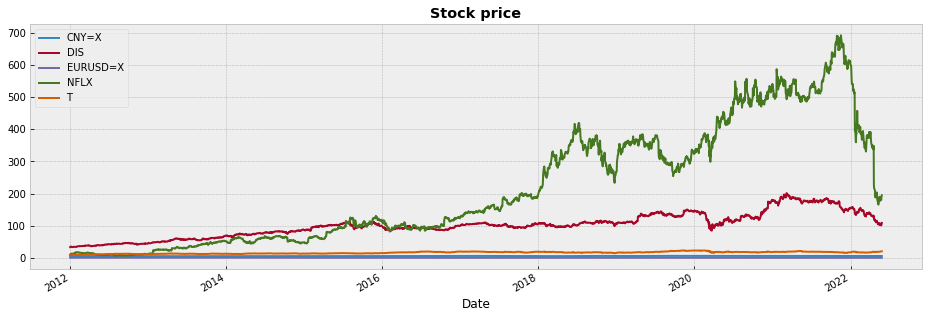

In [6]:
prices.plot(figsize=(16, 5))
plt.title("Stock price", weight="bold")

plt.show()

### 2) Преобразование данных (0.2 балла)

Переведите цены в доходности. Можно использовать разности или процентные изменения на выбор.

In [7]:
# Используем процентные изменения
returns = prices.pct_change().dropna()
returns.head()

,CNY=X,DIS,EURUSD=X,NFLX,T
Date,,,,,
2012-01-04,0.002069,0.014096,0.008891,0.113649,0.001646
2012-01-05,-0.000159,0.016731,-0.009543,-0.014295,-0.000986
2012-01-06,0.001985,0.010380,-0.010467,0.088146,-0.004610
2012-01-09,-0.001442,-0.004009,-0.009041,0.137791,-0.000674
2012-01-10,0.002159,-0.003019,0.007538,-0.023936,0.003371


### 3) Визуализация. (2 балла)


* Изобразите парные диаграммы рассеяния (scatterplot) для всех комбинаций инструментов. В каких парах наблюдается связь, а в каких нет? Кратко интерпретируйте зависимость по одному примеру из предыдущего вопроса (один где есть зависимость, другой где нет). Если во всех парах есть зависимость (или во всех нет), то достаточно одного примера. (0.5 балла)

* Изобразите гистограмму распределения каждого инструмента, наложив на неё оценённое нормальное распределение. Что можно сказать о характеристиках распределения доходностей (скошенность и тяжесть хвостов)? (1 балл).

* В качестве весов портфеля используйте веса на момент покупки (как в семинаре). Изобразите  гистограмму распределения доходностей портфеля, наложив на неё оценённое нормальное распределение. Что можно сказать о характеристиках распределения доходностей (скошенность и тяжесть хвостов)? (0.5 балла)

<Figure size 504x504 with 0 Axes>

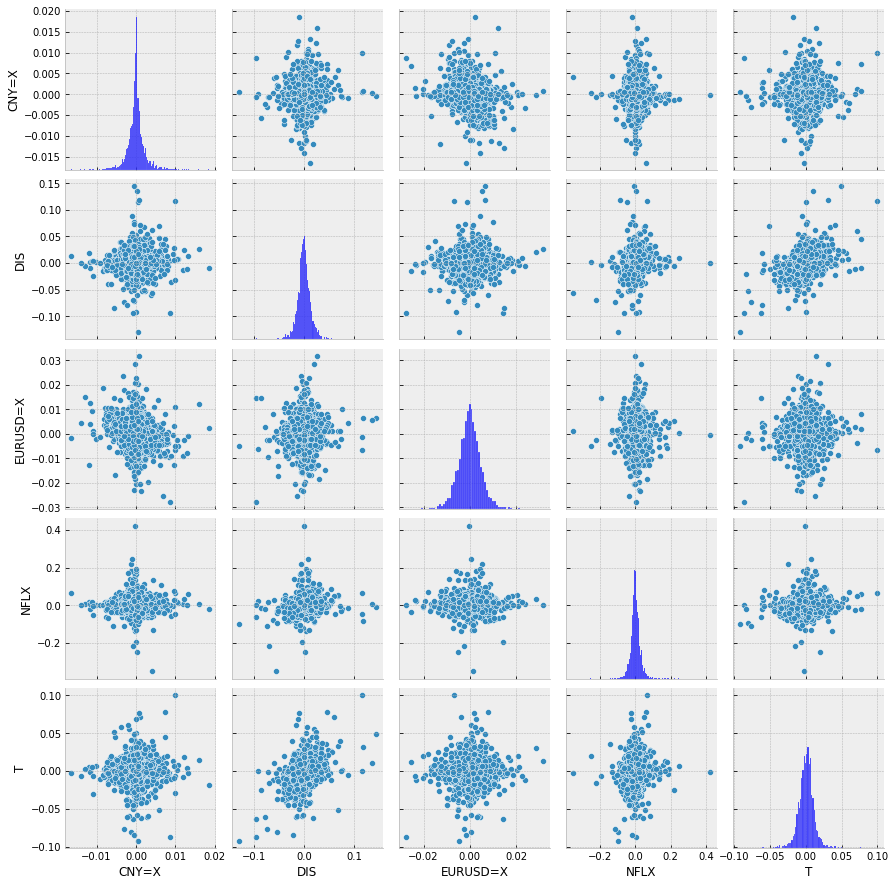

In [8]:
# Парные диаграммы рассеяния

fig = plt.figure(figsize=(7, 7))
sns.pairplot(returns)
plt.show()

**Интерпретация**:

1. В парах между инвестиционными банками Goldman Sachs и JP Morgan взаимосвязь наблюдается: чем выше доходность по одному инструменту, тем выше доходность по-другому.

2. В парах между валютной парой GBPUSD и доходностями Goldman Sachs доходности не наблюдается, поскольку образуется "облако" около нуля.

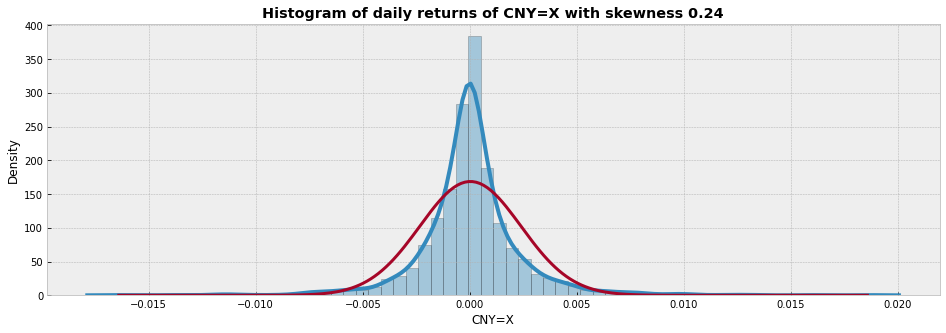

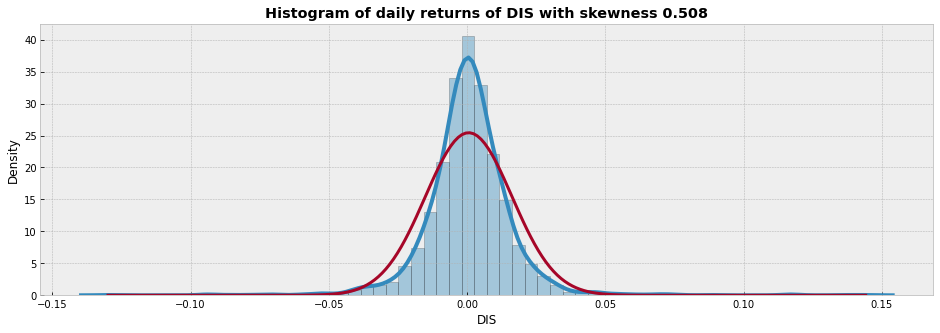

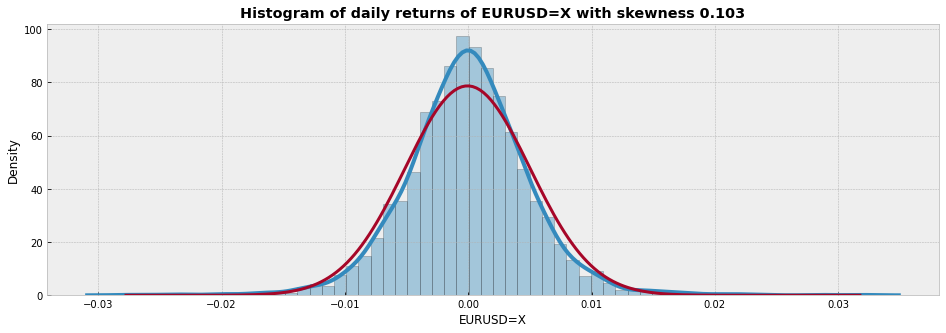

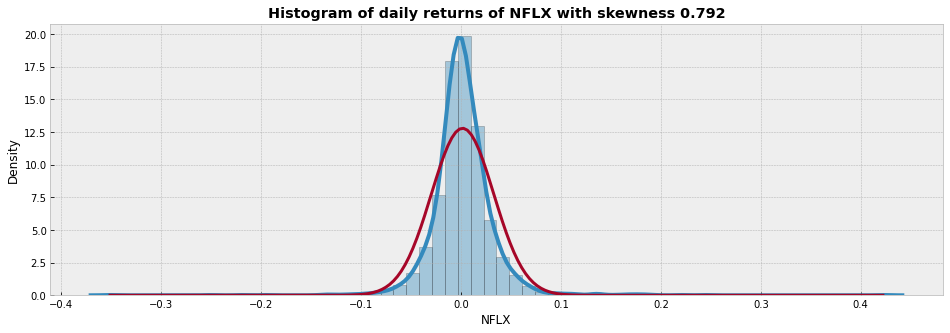

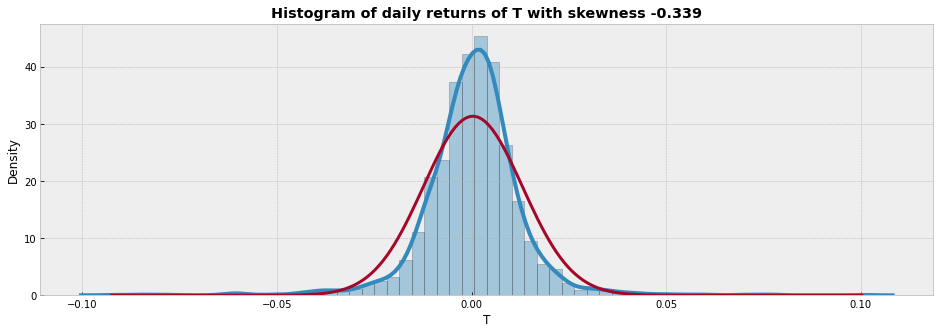

In [9]:
# Распределение доходностей каждого инструмента

for ret in returns.columns:

    fig = plt.figure(figsize=(16, 5))
    x = np.linspace(returns[ret].min(), returns[ret].max(), 200)

    sns.distplot(returns[ret], hist=True, kde=True, 
                 bins=60,
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 4})

    params_norm = ss.norm.fit(returns[ret])
    y_pdf = ss.norm.pdf(x, *params_norm)
    plt.plot(x, y_pdf, linewidth=3)
    
    skew = np.round(ss.skew(returns[ret]), 3)

    plt.title(f"Histogram of daily returns of {ret} with skewness {skew}", weight="bold")
    plt.show()

**Интерпретация**:

1. EURUSD=X: скошенность вправо (правый хвост немного длиннее левого), хвосты тяжелые (содержат довольно много значений)

2. GBPUSD=X: скошенность влево (левый хвост сильно длиннее правого), хвосты тяжелые (содержат довольно много значений)

3. GS: скошенность практически отсутствует (хвосты практически одинаковой длины), хвосты тяжелые (содержат довольно много значений)

4. JPM: скошенность вправо (правый хвост немного длиннее левого), хвосты тяжелые (содержат довольно много значений)

5. MS: скошенность вправо (правый хвост немного длиннее левого), хвосты тяжелые (содержат довольно много значений)

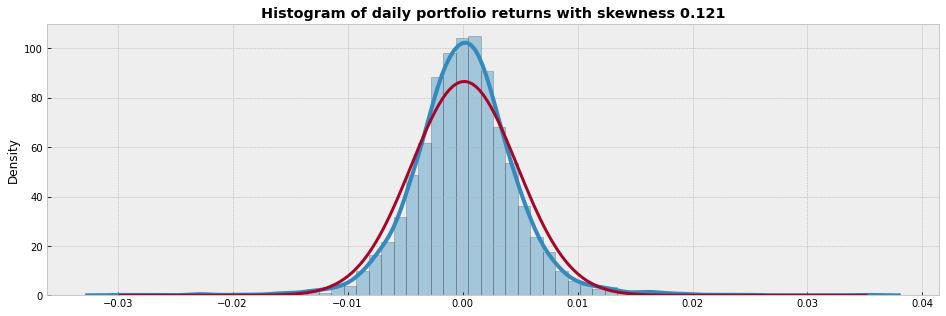

In [10]:
# Распределение доходностей портфеля

w = 1 / prices.iloc[0]
w = w / w.sum()
portfolio_real_returns = np.dot(returns.values, w)

portfolio_real_returns_selected = pd.Series(portfolio_real_returns, index=returns.index)

fig = plt.figure(figsize=(16, 5))
x = np.linspace(portfolio_real_returns_selected.min(), portfolio_real_returns_selected.max(), 200)

sns.distplot(portfolio_real_returns_selected, hist=True, kde=True, 
            bins=60,
            hist_kws={'edgecolor':'black'},
            kde_kws={'linewidth': 4})

params_norm = ss.norm.fit(portfolio_real_returns_selected)
y_pdf = ss.norm.pdf(x, *params_norm)
plt.plot(x, y_pdf, linewidth=3)

skew = np.round(ss.skew(portfolio_real_returns_selected), 3)
    
plt.title(f"Histogram of daily portfolio returns with skewness {skew}", weight="bold")
plt.show()

**Интерпретация**:

1. Сильная скошенность влево (левый хвост намного длиннее правого, рассчитаный показатель равен -0.369).
2. У эмпирического распределения хвосты тяжелее, чем у оцененного нормального.

### 4) Анализ отдельных инструментов. (2.5 балла, по 0.5 за инструмент)

* Подберите для каждого инструмента наиболее подходящее маржинальное распределение. Можно использовать всё, что есть в scipy, а также garch-модель. 
* Для каждого результата изобразите калибровочную кривую (qq-plot), а также наложите оценённую функцию плотности на гистограмму распределения доходности. Обратите внимание, что для GARCH-модели распределение остатков стандартизировано, поэтому для визуализации придётся оценить модель и получить её остатки, а не накладывать плотность GARCH на исходные доходности.
* NB! Постарайтесь подобрать распределение как можно точнее, от этого существенно зависит итоговый результат.

In [11]:
cdfs = pd.DataFrame()
distribution_params = pd.DataFrame()

#### 1. EURUSD=X: GARCH Model

In [12]:
scaling_const = 10.0 / returns['EURUSD=X'].std()

mdl = arch_model(
    y=scaling_const * returns['EURUSD=X'],
    mean='HARX', lags=1, 
    vol='Garch', p=1, o=1, q=1, 
    dist='t' 
) 

res = mdl.fit(disp='off')
cdf = mdl.distribution.cdf(res.resid.dropna(), res.params[-1:])
distribution_params['EURUSD=X'] = (mdl, res, scaling_const,'t')
cdfs['EURUSD=X']=cdf  

res

                           HAR - GJR-GARCH Model Results                            
Dep. Variable:                     EURUSD=X   R-squared:                       0.002
Mean Model:                             HAR   Adj. R-squared:                  0.001
Vol Model:                        GJR-GARCH   Log-Likelihood:               -9501.29
Distribution:      Standardized Student's t   AIC:                           19016.6
Method:                  Maximum Likelihood   BIC:                           19057.7
                                              No. Observations:                 2611
Date:                      Tue, May 31 2022   Df Residuals:                     2609
Time:                              13:57:43   Df Model:                            2
                                   Mean Model                                   
                    coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------------------------------------------------------

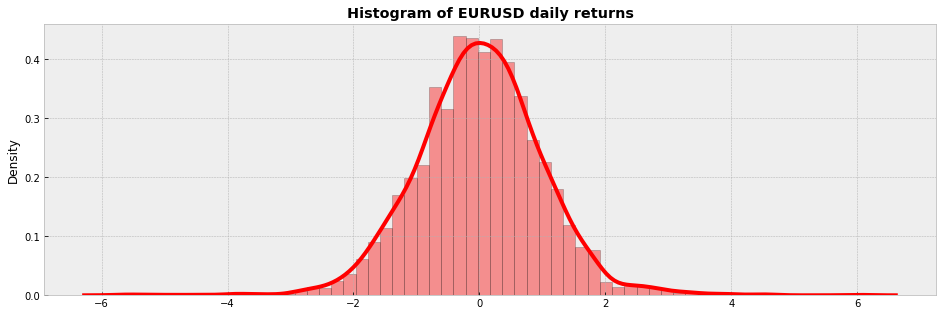

In [13]:
stand_residuals = res.resid / res.conditional_volatility
stand_residuals = stand_residuals.dropna()

fig = plt.figure(figsize=(16, 5))

sns.distplot(stand_residuals, hist=True, kde=True, 
            bins=60,
            hist_kws={'edgecolor':'black'},
            kde_kws={'linewidth': 4}, color='r')

plt.title(f"Histogram of EURUSD daily returns", weight="bold")
plt.show()

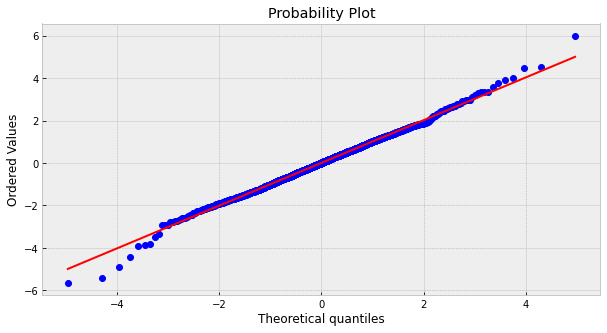

In [14]:
fig = plt.figure(figsize=(10, 5))
ss.probplot(stand_residuals, dist=mdl.distribution, sparams=(res.params[-1:],), plot=plt)
plt.show()

#### 2. CNY=X: Garch Model

In [15]:
scaling_const = 10.0 / returns['CNY=X'].std()

mdl = arch_model(
    y=scaling_const * returns['CNY=X'],
    mean='HARX', lags=1, 
    vol='Garch', p=1, o=1, q=1, 
    dist='t' 
) 

res = mdl.fit(disp='off')
cdf = mdl.distribution.cdf(res.resid.dropna(), res.params[-1:])
distribution_params['CNY=X'] = (mdl, res, scaling_const,'t')
cdfs['CNY=X']=cdf  

res

                           HAR - GJR-GARCH Model Results                            
Dep. Variable:                        CNY=X   R-squared:                       0.009
Mean Model:                             HAR   Adj. R-squared:                  0.009
Vol Model:                        GJR-GARCH   Log-Likelihood:               -8962.16
Distribution:      Standardized Student's t   AIC:                           17938.3
Method:                  Maximum Likelihood   BIC:                           17979.4
                                              No. Observations:                 2611
Date:                      Tue, May 31 2022   Df Residuals:                     2609
Time:                              13:57:44   Df Model:                            2
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const  

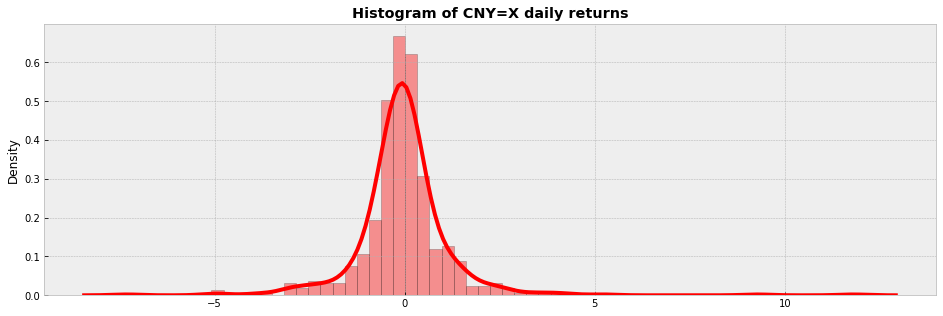

In [16]:
stand_residuals = res.resid / res.conditional_volatility
stand_residuals = stand_residuals.dropna()

fig = plt.figure(figsize=(16, 5))

sns.distplot(stand_residuals[:500], hist=True, kde=True, 
            bins=60,
            hist_kws={'edgecolor':'black'},
            kde_kws={'linewidth': 4}, color='r')

plt.title(f"Histogram of CNY=X daily returns", weight="bold")
plt.show()

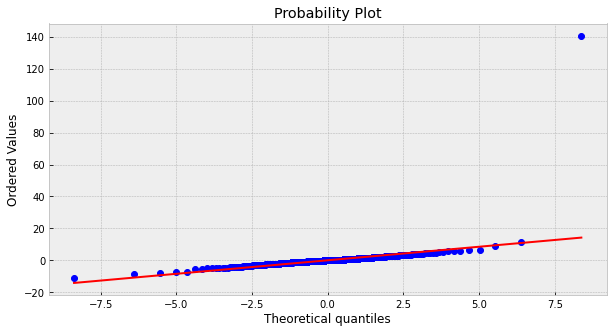

In [17]:
fig = plt.figure(figsize=(10, 5))
ss.probplot(stand_residuals, dist=mdl.distribution, sparams=(res.params[-1:],), plot=plt)
plt.show()

#### 3. Goldman Sachs: GARCH model

In [18]:
scaling_const = 10.0 / returns['T'].std()

mdl = arch_model(
    y=scaling_const * returns['T'],
    mean='HARX', lags=1, 
    vol='Garch', p=1, o=1, q=1, 
    dist='t' 
) 

res = mdl.fit(disp='off', tol = 1e-7)
cdf = mdl.distribution.cdf(res.resid.dropna(), res.params[-1:])
distribution_params['T'] = (mdl, res, scaling_const,'t')
cdfs['T']=cdf  

res

                           HAR - GJR-GARCH Model Results                            
Dep. Variable:                            T   R-squared:                       0.001
Mean Model:                             HAR   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -9219.02
Distribution:      Standardized Student's t   AIC:                           18452.0
Method:                  Maximum Likelihood   BIC:                           18493.1
                                              No. Observations:                 2611
Date:                      Tue, May 31 2022   Df Residuals:                     2609
Time:                              13:57:45   Df Model:                            2
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
C

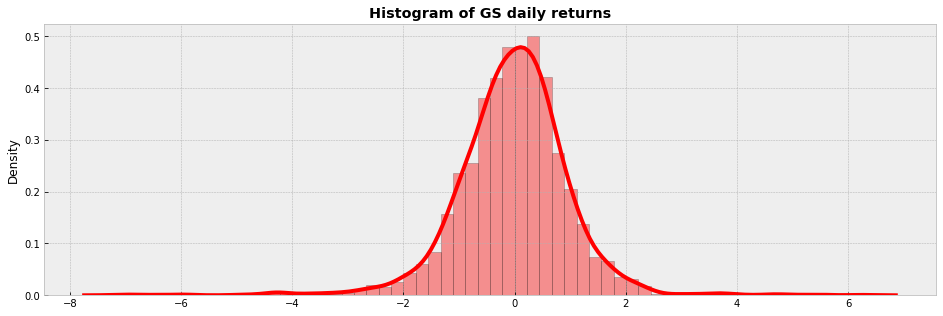

In [19]:
stand_residuals = res.resid / res.conditional_volatility
stand_residuals = stand_residuals.dropna()

fig = plt.figure(figsize=(16, 5))
x = np.linspace(stand_residuals.min(), stand_residuals.max(), 200)

sns.distplot(stand_residuals, hist=True, kde=True, 
            bins=60,
            hist_kws={'edgecolor':'black'},
            kde_kws={'linewidth': 4}, color='r')

plt.title(f"Histogram of GS daily returns", weight="bold")
plt.show()

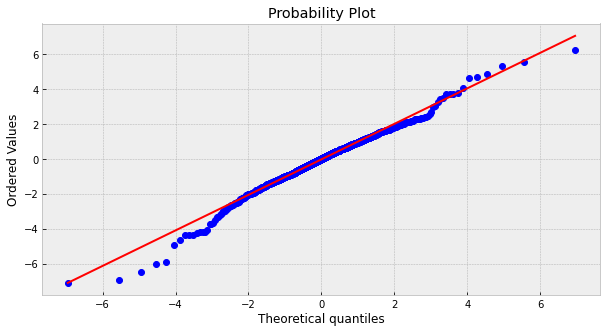

In [20]:
fig = plt.figure(figsize=(10, 5))
ss.probplot(stand_residuals, dist=mdl.distribution, sparams=(res.params[-1:],), plot=plt)
plt.show()

#### 4. JP Morgan: GARCH Model

In [21]:
scaling_const = 10.0 / returns['DIS'].std()

mdl = arch_model(
    y=scaling_const * returns['DIS'],
    mean='HARX', lags=1, 
    vol='Garch', p=1, o=0, q=1, 
    dist='t' 
) 

res = mdl.fit(disp='off')
cdf = mdl.distribution.cdf(res.resid.dropna(), res.params[-1:])
distribution_params['DIS'] = (mdl, res, scaling_const,'t')
cdfs['DIS']=cdf  

res

                             HAR - GARCH Model Results                              
Dep. Variable:                          DIS   R-squared:                       0.004
Mean Model:                             HAR   Adj. R-squared:                  0.004
Vol Model:                            GARCH   Log-Likelihood:               -9133.22
Distribution:      Standardized Student's t   AIC:                           18278.4
Method:                  Maximum Likelihood   BIC:                           18313.7
                                              No. Observations:                 2611
Date:                      Tue, May 31 2022   Df Residuals:                     2609
Time:                              13:57:46   Df Model:                            2
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
C

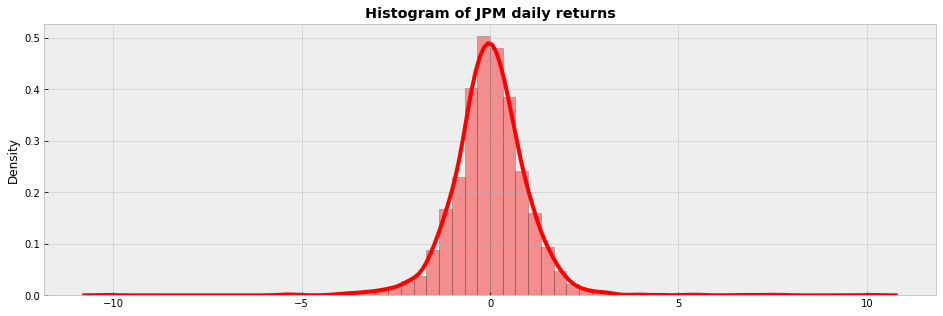

In [22]:
stand_residuals = res.resid / res.conditional_volatility
stand_residuals = stand_residuals.dropna()

fig = plt.figure(figsize=(16, 5))
x = np.linspace(stand_residuals.min(), stand_residuals.max(), 200)

sns.distplot(stand_residuals, hist=True, kde=True, 
            bins=60,
            hist_kws={'edgecolor':'black'},
            kde_kws={'linewidth': 4}, color='r')

plt.title(f"Histogram of JPM daily returns", weight="bold")
plt.show()

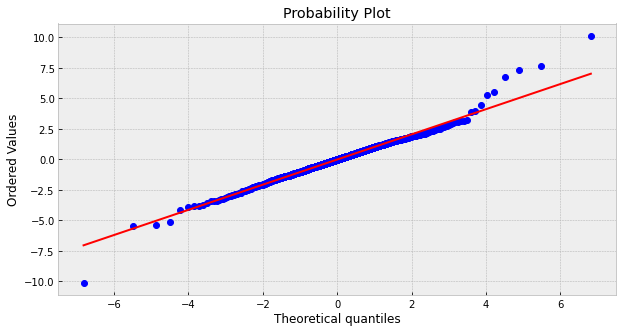

In [23]:
fig = plt.figure(figsize=(10, 5))
ss.probplot(stand_residuals, dist=mdl.distribution, sparams=(res.params[-1:],), plot=plt)
plt.show()

#### 5. Morgan Stanley: GARCH Model

In [24]:
scaling_const = 10.0 / returns['NFLX'].std()

mdl = arch_model(
    y=scaling_const * returns['NFLX'],
    mean='HARX', lags=1, 
    vol='Garch', p=1, o=1, q=1, 
    dist='t' 
) 

res = mdl.fit(disp='off')
cdf = mdl.distribution.cdf(res.resid.dropna(), res.params[-1:])
distribution_params['NFLX'] = (mdl, res, scaling_const,'t')
cdfs['NFLX']=cdf  

res

                           HAR - GJR-GARCH Model Results                            
Dep. Variable:                         NFLX   R-squared:                      -0.004
Mean Model:                             HAR   Adj. R-squared:                 -0.004
Vol Model:                        GJR-GARCH   Log-Likelihood:               -9077.46
Distribution:      Standardized Student's t   AIC:                           18168.9
Method:                  Maximum Likelihood   BIC:                           18210.0
                                              No. Observations:                 2611
Date:                      Tue, May 31 2022   Df Residuals:                     2609
Time:                              13:57:46   Df Model:                            2
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
C

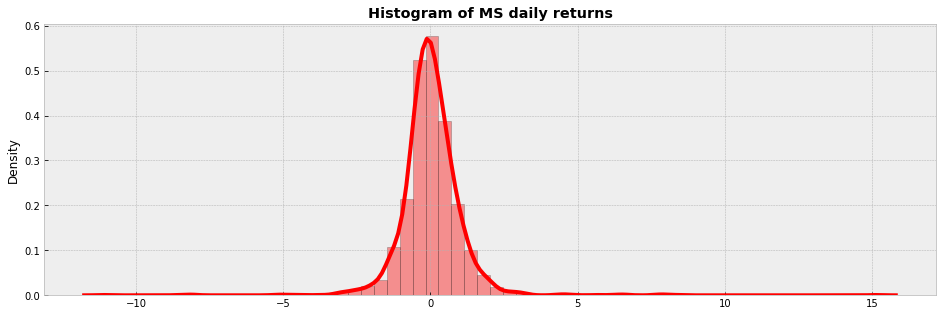

In [25]:
stand_residuals = res.resid / res.conditional_volatility
stand_residuals = stand_residuals.dropna()

fig = plt.figure(figsize=(16, 5))
x = np.linspace(stand_residuals.min(), stand_residuals.max(), 200)

sns.distplot(stand_residuals, hist=True, kde=True, 
            bins=60,
            hist_kws={'edgecolor':'black'},
            kde_kws={'linewidth': 4}, color='r')

plt.title(f"Histogram of MS daily returns", weight="bold")
plt.show()

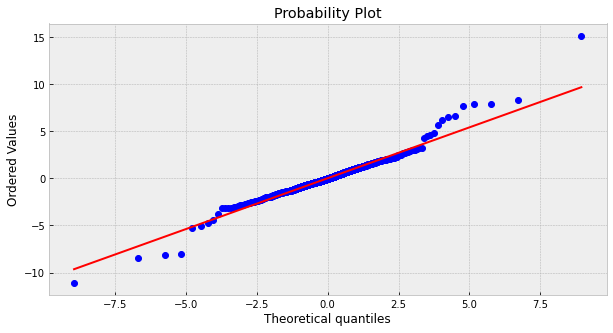

In [26]:
fig = plt.figure(figsize=(10, 5))
ss.probplot(stand_residuals, dist=mdl.distribution, sparams=(res.params[-1:],), plot=plt)
plt.show()

### 5) Копулы (1.5 балла)

* Определитесь с количеством копул. Так как наш пример не очень большой размерности, можно обойтись одной копулой на все инструменты сразу. Но если они не связаны (например, Российские акции и какие-нибудь скандинавские валюты), повышать разменость копулы может быть бессмысленно. В таком случае можно попробовать построить две копулы: одну на акции, другую на валюты. 

* Проведите преобразование, переводящее доходности на единичный куб. Воспользуйтесь функциями распределения из пункта 4. Опять же, обратите внимание, что GARCH необходимо обрабатывать отдельно.

* Для каждого случая отберите наилучшую по AIC копулу из Архимедовых. Архимедовыми копулами ограничимся с целью ускорения будущих расчётов. Оценивайте

In [27]:
#!pip install copulae
from copulae import NormalCopula, StudentCopula, ClaytonCopula, GumbelCopula, FrankCopula

In [28]:
norm_cop = NormalCopula(dim=cdfs.shape[1])
norm_cop.fit(cdfs)
print('NormalCopula AIC:',2 - 2*norm_cop.log_lik(cdfs))

          EURUSD=X        CNY=X            T          DIS         NFLX
count  2611.000000  2611.000000  2611.000000  2611.000000  2611.000000
mean      0.500000     0.500000     0.500000     0.500000     0.500000
std       0.288620     0.288619     0.288620     0.288620     0.288620
min       0.000383     0.000383     0.000383     0.000383     0.000383
25%       0.250191     0.250191     0.250191     0.250191     0.250191
50%       0.500000     0.506508     0.500000     0.500000     0.500000
75%       0.749809     0.749809     0.749809     0.749809     0.749809
max       0.999617     0.999617     0.999617     0.999617     0.999617
NormalCopula AIC: -854.2194606271416


In [29]:
stud_cop = StudentCopula(dim=cdfs.shape[1])
stud_cop.fit(cdfs)
print('StudentCopula AIC:',2 - 2*stud_cop.log_lik(cdfs))

          EURUSD=X        CNY=X            T          DIS         NFLX
count  2611.000000  2611.000000  2611.000000  2611.000000  2611.000000
mean      0.500000     0.500000     0.500000     0.500000     0.500000
std       0.288620     0.288619     0.288620     0.288620     0.288620
min       0.000383     0.000383     0.000383     0.000383     0.000383
25%       0.250191     0.250191     0.250191     0.250191     0.250191
50%       0.500000     0.506508     0.500000     0.500000     0.500000
75%       0.749809     0.749809     0.749809     0.749809     0.749809
max       0.999617     0.999617     0.999617     0.999617     0.999617
StudentCopula AIC: -983.2837778443256


In [30]:
clay_cop = ClaytonCopula(dim=cdfs.shape[1])
clay_cop.fit(cdfs)
print('ClaytonCopula AIC:',2 - 2*clay_cop.log_lik(cdfs))

          EURUSD=X        CNY=X            T          DIS         NFLX
count  2611.000000  2611.000000  2611.000000  2611.000000  2611.000000
mean      0.500000     0.500000     0.500000     0.500000     0.500000
std       0.288620     0.288619     0.288620     0.288620     0.288620
min       0.000383     0.000383     0.000383     0.000383     0.000383
25%       0.250191     0.250191     0.250191     0.250191     0.250191
50%       0.500000     0.506508     0.500000     0.500000     0.500000
75%       0.749809     0.749809     0.749809     0.749809     0.749809
max       0.999617     0.999617     0.999617     0.999617     0.999617
ClaytonCopula AIC: -117.95708486914961


In [31]:
gumb_cop = GumbelCopula(dim=cdfs.shape[1])
gumb_cop.fit(cdfs)
print('GumbelCopula AIC:',2 - 2*gumb_cop.log_lik(cdfs))

          EURUSD=X        CNY=X            T          DIS         NFLX
count  2611.000000  2611.000000  2611.000000  2611.000000  2611.000000
mean      0.500000     0.500000     0.500000     0.500000     0.500000
std       0.288620     0.288619     0.288620     0.288620     0.288620
min       0.000383     0.000383     0.000383     0.000383     0.000383
25%       0.250191     0.250191     0.250191     0.250191     0.250191
50%       0.500000     0.506508     0.500000     0.500000     0.500000
75%       0.749809     0.749809     0.749809     0.749809     0.749809
max       0.999617     0.999617     0.999617     0.999617     0.999617
GumbelCopula AIC: -51.972480291565304


In [32]:
fran_cop = FrankCopula(dim=cdfs.shape[1])
fran_cop.fit(cdfs)
print('FrankCopula AIC:',2 - 2*fran_cop.log_lik(cdfs))

          EURUSD=X        CNY=X            T          DIS         NFLX
count  2611.000000  2611.000000  2611.000000  2611.000000  2611.000000
mean      0.500000     0.500000     0.500000     0.500000     0.500000
std       0.288620     0.288619     0.288620     0.288620     0.288620
min       0.000383     0.000383     0.000383     0.000383     0.000383
25%       0.250191     0.250191     0.250191     0.250191     0.250191
50%       0.500000     0.506508     0.500000     0.500000     0.500000
75%       0.749809     0.749809     0.749809     0.749809     0.749809
max       0.999617     0.999617     0.999617     0.999617     0.999617
FrankCopula AIC: -49.21002506053793


### 6) VaR и ES (2.5 балла)

С помощью выбранных распределений и копул постройте VaR-кривую и ES-кривую. Можете пользоваться функциями с семинара и модифицировать их по необходимости. 

In [33]:
def garch_copula_simulation(returns):
    
    cdfs = pd.DataFrame()
    sim_returns = pd.DataFrame()
    distribution_params = pd.DataFrame()
    
    for name in returns.columns:
        
        if name == 'T':
            scaling_const = 10.0 / returns['T'].std()

            am = arch_model(returns['T']* scaling_const,
                        mean='HARX', lags=1,
                        vol='GARCH', p=1, o=1, q=1, 
                        dist='t')
            res = am.fit(update_freq=0, disp='off')
            cdf = am.distribution.cdf(res.resid.dropna(), res.params[-1:])
            distribution_params[name] = (am, res, scaling_const,'t')
            cdfs[name]=cdf
            
        elif name == 'EURUSD=X':
            scaling_const = 10.0 / returns['EURUSD=X'].std()
            am = arch_model(returns['EURUSD=X']* scaling_const,
                        mean='HARX', lags=1,
                        vol='GARCH', p=1, o=1, q=1,
                        power = 2,
                        dist='ged')
            res = am.fit(update_freq=0, disp='off')
            cdf = am.distribution.cdf(res.resid.dropna(), res.params[-1:])
            distribution_params[name] = (am, res, scaling_const,'ged')
            cdfs[name]=cdf
            
        elif name == 'CNY=X':
            scaling_const = 10.0 / returns['CNY=X'].std()
            am = arch_model(returns['CNY=X']* scaling_const,
                        mean='HARX', lags=1,
                        vol='GARCH', p=1, o=1, q=1,
                        dist='t')
            res = am.fit(update_freq=0, disp='off')
            cdf = am.distribution.cdf(res.resid.dropna(), res.params[-1:])
            distribution_params[name] = (am, res, scaling_const,'t')
            cdfs[name]=cdf
            
        elif name == 'DIS':
            scaling_const = 10.0 / returns['DIS'].std()
            am = arch_model(returns['DIS']* scaling_const,
                        mean='HARX', lags=1,
                        vol='GARCH', p=1, o=0, q=1,
                        dist='t')
            res = am.fit(update_freq=0, disp='off')
            cdf=am.distribution.cdf(res.resid.dropna(), res.params[-1:])
            distribution_params[name] = (am, res, scaling_const,'t')
            cdfs[name]=cdf
            
        else:
            scaling_const = 10.0 / returns['NFLX'].std()
            am = arch_model(returns['NFLX']* scaling_const,
                        mean='HARX', lags=1,
                        vol='GARCH', p=1, o=1, q=1,
                        dist='t')
            res = am.fit(update_freq=0, disp='off')
            cdf=am.distribution.cdf(res.resid.dropna(), res.params[-1:])
            distribution_params[name] = (am, res, scaling_const,'t')
            cdfs[name]=cdf
            
    cop = ClaytonCopula(dim=cdfs.shape[1])
    cop.fit(cdfs)
    copula_simulations = cop.random(10**4)
    copula_simulations = pd.DataFrame(copula_simulations, columns=cdfs.columns)
    for name in returns.columns:
        am, res, scaling_const, dist = distribution_params[name]
        forecasts = res.forecast(horizon=1)

        cond_mean = float(forecasts.mean.iloc[-1])
        cond_var = float(forecasts.variance.iloc[-1])

        if dist == 't' or dist == 'ged':
            q = am.distribution.ppf(copula_simulations[name], res.params[-1:])
        elif dist == 'skewt':
            q = am.distribution.ppf(copula_simulations[name], res.params[-2:])
        sim_returns[name] = (cond_mean + np.sqrt(cond_var) * q) / scaling_const
    return sim_returns

In [34]:
def calc_VaR_ES(r, garch_copula_simulation, w, L_history=252, level=0.05):
    
    VaR = np.full(r.shape[0], np.nan)
    ES = np.full(r.shape[0], np.nan)
    
    for i in range(L_history, r.shape[0]):
        history = r[i - L_history: i]
        
        try:
            return_simulations = garch_copula_simulation(history)
            portfolio_simulated_returns = np.dot(return_simulations.values, w)

            VaR[i] = np.quantile(portfolio_simulated_returns, level)
            ES[i] = portfolio_simulated_returns[portfolio_simulated_returns<VaR[i]].mean()
            
        except:
            VaR[i] = VaR[i-1]
            ES[i] = ES[i-1]
        
    res = pd.DataFrame()
    res['VaR'] = VaR
    res['ES'] = ES
    
    return res

In [35]:
%%time
VaR_ES = calc_VaR_ES(returns, garch_copula_simulation, w)

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287426    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.914683    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287426    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287856    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.938492    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287902    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287902    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.942460    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287923    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287959    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.948413    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287959    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287830    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.936508    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287880    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287902    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.942460    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287942    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287803    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.934524    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287774    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287711    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.928571    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287640    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287880    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.940476    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287901    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287640    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.924603    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287640    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288065    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.966270    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288065    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288049    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.962302    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288039    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288049    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.962302    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288049    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288071    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.968254    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288071    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.288077    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.970238    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.288071    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.288086    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.974206    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.288082    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.288082    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.994048    0.972222    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.288082    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.288086    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.994048    0.974206    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.288086    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.288082    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.972222    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.288082    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.288090    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.976190    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.288090    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288093    0.288102    0.288090    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.976190    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288093    0.288102    0.288090    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288093    0.288102    0.288093    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.978175    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288093    0.288102    0.288093    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288093    0.288102    0.288095    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.509921    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.980159    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288093    0.288102    0.288095    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288093    0.288102    0.288093    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.509921    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.978175    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288093    0.288102    0.288093    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288090    0.288102    0.288093    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.488095    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.978175    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288090    0.288102    0.288095    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288090    0.288102    0.288095    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.980159    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288090    0.288102    0.288097    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288095    0.288102    0.288082    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.972222    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288095    0.288102    0.288086    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288095    0.288102    0.288090    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.492063    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.976190    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288095    0.288102    0.288057    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288095    0.288102    0.287923    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.492063    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.944444    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288095    0.288102    0.287902    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288095    0.288102    0.287902    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.496032    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.942460    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288095    0.288102    0.287803    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288095    0.288102    0.288095    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.503968    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.980159    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288095    0.288102    0.288097    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.288097    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.509921    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.982143    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.288095    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.288093    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.498016    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.978175    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.288093    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.288086    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.974206    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.288086    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.288090    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.976190    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.288090    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.288077    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.509921    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.970238    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.288082    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288101    0.288090    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.498016    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.988095    0.976190    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288101    0.288090    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288101    0.288086    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.486111    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.988095    0.974206    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288101    0.288086    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288101    0.288102    0.288093    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.978175    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288101    0.288102    0.288093    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.288095    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.494048    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.980159    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.288095    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288099    0.288102    0.288090    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.511905    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.976190    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288099    0.288102    0.288090    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288099    0.288102    0.288082    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.511905    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.972222    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288099    0.288102    0.288082    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.288049    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.962302    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.288049    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.288039    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.960317    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.288039    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.287991    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.952381    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.288005    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.288005    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.509921    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.954365    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.288005    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.287991    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.505952    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.952381    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.287976    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.287942    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.946429    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.287942    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.287831    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.936508    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.287831    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.287856    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.938492    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.287856    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.287856    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.509921    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.938492    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.287856    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.287976    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.950397    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.287976    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.287976    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.486111    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.950397    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.287976    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.288064    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.966270    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.288064    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.288039    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.486111    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.960317    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.288057    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.288057    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.964286    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.288049    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

/Users/sergeytikhonov/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288090    0.288102    0.288057    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.488095    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.964286    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288090    0.288102    0.288065    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288095    0.288102    0.288029    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.958333    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288095    0.288102    0.288029    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.288065    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.966270    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.288049    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.288086    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.974206    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.288057    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.288071    0.288102    0.288049
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.968254    0.996032    0.962302
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.288071    0.288102    0.288057
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.288082    0.288102    0.288100
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.972222    0.996032    0.986111
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.288082    0.288102    0.288100
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.288082    0.288102    0.288094
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.972222    0.996032    0.980159
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.288086    0.288102    0.288071
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.288090    0.288102    0.287774
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.976190    0.996032    0.932540
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.288090    0.288102    0.287831
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.288097    0.288102    0.288071
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.982143    0.996032    0.968254
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288097    0.288102    0.288097    0.288102    0.288090
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.288097    0.288102    0.288095
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.982143    0.996032    0.980159
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.288095    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.288100    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.986111    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.288100    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.288100    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.986111    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.288099    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288100    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.986111    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288100    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288095    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.980159    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288095    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288093    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.978175    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288090    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288057    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.964286    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288071    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288077    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.970238    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288077    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288048    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.962302    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288057    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288029    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.958333    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288029    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288018    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.956349    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288018    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288005    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.954365    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288018    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287991    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.952381    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287991    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288029    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.958333    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288029    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287942    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.946429    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287942    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

/Users/sergeytikhonov/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.286818    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.894841    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.286819    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

/Users/sergeytikhonov/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287271    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.908730    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287214    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287271    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.908730    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287271    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287029    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.900794    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.286961    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287155    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.904762    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287028    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287214    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.906746    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287271    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287426    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.914683    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287377    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287214    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.906746    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287214    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.286961    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.898810    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.286819    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287677    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.926587    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287677    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287602    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.922619    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287640    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287602    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.922619    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287602    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287602    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.922619    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287677    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287602    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.922619    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287561    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287377    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.912698    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287377    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287774    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.932540    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287803    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287960    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.948413    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287942    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287942    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.946429    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287976    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288018    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.956349    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288005    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288018    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.956349    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288029    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287991    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.952381    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287976    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288029    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.958333    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288039    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288005    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.954365    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288005    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287976    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.950397    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287960    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287902    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.942460    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287880    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287902    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.942460    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287856    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287774    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.932540    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287473    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287325    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.910714    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287377    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287519    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.918651    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287519    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287744    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.930556    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287856    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287880    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.940476    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287880    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287803    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.934524    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287831    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287880    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.940476    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287923    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287880    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.940476    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287880    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287474    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.916667    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287519    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287561    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.920635    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287561    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287960    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.948413    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287960    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287922    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.944444    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287923    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287976    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.950397    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287976    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287831    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.936508    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287831    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287923    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.944444    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287923    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287942    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.946429    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287942    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288029    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.958333    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288029    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288039    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.960317    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288039    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288049    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.962302    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.288057    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288101    0.288102    0.287991    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.952381    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288101    0.288102    0.288005    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288101    0.288102    0.287976    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.950397    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288101    0.288102    0.288049    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288101    0.288102    0.288065    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.966270    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288101    0.288102    0.288065    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288101    0.288102    0.288090    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.976190    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288101    0.288102    0.288082    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288101    0.288102    0.288077    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.970238    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288101    0.288102    0.288082    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288101    0.288102    0.288082    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.492063    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.972222    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288101    0.288102    0.288077    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288101    0.288102    0.288065    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.507937    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.966270    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288101    0.288102    0.288065    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288101    0.288102    0.288057    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.964286    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.288057    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.288049    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.962302    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.288057    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.287922    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.944444    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.287922    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.287923    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.944444    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.287942    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.287942    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.946429    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.287902    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288100    0.288102    0.287880    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.940476    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288099    0.288102    0.287880    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288099    0.288102    0.287803    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.934524    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288099    0.288102    0.287803    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288099    0.288102    0.287711    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.928571    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288099    0.288102    0.287711    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288099    0.288102    0.287774    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.932540    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288099    0.288102    0.287775    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288099    0.288102    0.287677    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.926587    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288099    0.288102    0.287744    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288099    0.288102    0.287677    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.926587    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288099    0.288102    0.287677    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287677    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.926587    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287640    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287029    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.900794    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.286961    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.285349    0.288102    0.288102
min      0.003968    0.003968    0.005952    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.865079    0.748016    0.748016
max      0.996032    0.996032    0.865079    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.284230    0.288102    0.288102
min      0.003968    0.003968    0.015873    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.283683    0.288102    0.288102
min      0.003968    0.003968    0.039683    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.843254    0.748016    0.748016
max      0.996032    0.996032    0.843254    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.283512    0.288102    0.288102
min      0.003968    0.003968    0.039683    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.283362    0.288102    0.288102
min      0.003968    0.003968    0.033730    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.839286    0.748016    0.748016
max      0.996032    0.996032    0.839286    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.283355    0.288102    0.288102
min      0.003968    0.003968    0.035714    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.284071    0.288102    0.288102
min      0.003968    0.003968    0.017857    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.847222    0.748016    0.748016
max      0.996032    0.996032    0.847222    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.283566    0.288102    0.288102
min      0.003968    0.003968    0.021825    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.284072    0.288102    0.288102
min      0.003968    0.003968    0.015873    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.847222    0.748016    0.748016
max      0.996032    0.996032    0.847222    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.284072    0.288102    0.288102
min      0.003968    0.003968    0.015873    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.285471    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.867063    0.748016    0.748016
max      0.996032    0.996032    0.867063    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.285471    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.285349    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.865079    0.748016    0.748016
max      0.996032    0.996032    0.865079    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.285224    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.286498    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.886905    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.286410    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.286664    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.890873    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.286664    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.286819    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.894841    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.286819    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287093    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.902778    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.286961    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287093    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.902778    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287093    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287803    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.934524    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287803    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287744    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.930556    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287677    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287518    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.918651    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287518    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287711    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.928571    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288102    0.288102    0.287744    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288101    0.288102    0.287856    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.938492    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288101    0.288102    0.287831    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288101    0.288102    0.287991    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.952381    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288101    0.288102    0.288005    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288101    0.288102    0.288095    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.980159    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288101    0.288102    0.288093    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288101    0.288102    0.288093    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.978175    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288101    0.288102    0.288093    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288101    0.288102    0.288082    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.972222    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288101    0.288102    0.288077    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288101    0.288102    0.288082    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0.500000    0.500000    0.500000    0.500000    0.500000
75%      0.748016    0.748016    0.748016    0.748016    0.748016
max      0.996032    0.996032    0.972222    0.996032    0.996032
            CNY=X         DIS    EURUSD=X        NFLX           T
count  251.000000  251.000000  251.000000  251.000000  251.000000
mean     0.500000    0.500000    0.500000    0.500000    0.500000
std      0.288101    0.288102    0.288077    0.288102    0.288102
min      0.003968    0.003968    0.003968    0.003968    0.003968
25%      0.251984    0.251984    0.251984    0.251984    0.251984
50%      0

In [36]:
VaR_ES.index = portfolio_real_returns_selected.index
VaR = VaR_ES['VaR']
ES = VaR_ES['ES']

### 7) Визуализация (0.4 балла)

Визуализируйте VaR и ES на графике с доходностями.

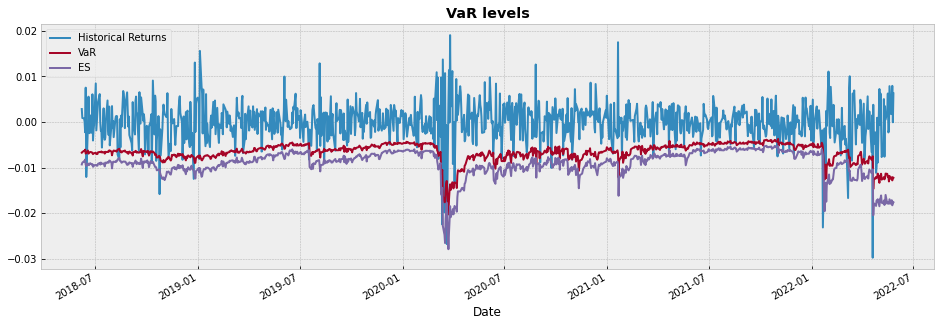

In [37]:
fig = plt.figure(figsize=(16, 5))

portfolio_real_returns_selected[-1000:].plot()

VaR[-1000:].plot()
ES[-1000:].plot()

plt.title("VaR levels", weight="bold")

plt.legend(['Historical Returns',
            'VaR',
            'ES'])

plt.show()

### 8) Бектестинг. (0.4 балла)

Проведите тесты на покрытие и независимость для VAR-кривой. Удалось ли пройти эти тесты?

In [38]:
def bern_test(p, v):
    
    lv = len(v)
    sv = sum(v)
    al = np.log(p)*sv + np.log(1-p)*(lv-sv)
    
    bl = np.log(sv/lv)*sv + np.log(1-sv/lv)*(lv-sv)
    
    return (-2*(al-bl))


def ind_test(V):
    
    J = np.full([len(V),4], 0)
    for i in range(1,len(V)-1):
        J[i,0] = (V[i-1] == 0) & (V[i] == 0)
        J[i,1] = (V[i-1] == 0) & (V[i] == 1)
        J[i,2] = (V[i-1] == 1) & (V[i] == 0)
        J[i,3] = (V[i-1] == 1) & (V[i] == 1)
        
    V_00 = sum(J[:,0])
    V_01 = sum(J[:,1])
    V_10 = sum(J[:,2])
    V_11 = sum(J[:,3])
    p_00=V_00/(V_00+V_01)
    p_01=V_01/(V_00+V_01)
    p_10=V_10/(V_10+V_11)
    p_11=V_11/(V_10+V_11)
    hat_p = (V_01+V_11)/(V_00+V_01+V_10+V_11)
    al = np.log(1-hat_p)*(V_00+V_10) + np.log(hat_p)*(V_01+V_11)
    bl = np.log(p_00)*V_00 + np.log(p_01)*V_01 + np.log(p_10)*V_10 + np.log(p_11)*V_11
    
    return (-2*(al-bl))


def backtest_results(ret, var_curve, alpha, significance=0.9):
    
    idx = var_curve.notna()
    
    violations = ret[idx] < var_curve[idx]
    
    coverage = bern_test(p=alpha, v=violations) < ss.chi2.ppf(significance, 1)
    independence = ind_test(violations) < ss.chi2.ppf(significance, 1)
        
    print('Target share of violations: {:.2f}%'.format(100*alpha))
    print('Observed share of violations: {:.2f}%'.format(100*violations.mean()))
    
    print('')
    
    if coverage:
        print('Test for coverage is passed')
    else:
        print('Test for coverage isn\'t passed')
        
    print('')
        
    if independence:
        print('Test for independence is passed')
    else:
        print('Test for independence isn\'t passed')

In [39]:
backtest_results(
    portfolio_real_returns_selected, 
    var_curve=VaR,
    alpha=0.05, 
    significance=0.95
)

Target share of violations: 5.00%
Observed share of violations: 4.53%

Test for coverage is passed

Test for independence is passed


##### Рубрика "как вам домашка?"
Поделитесь, что вам понравилось, а что нет. Это важно